In [1]:

# os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
# os.environ['https_proxy'] = 'http://10.16.35.10:13390' 
# os.environ['PATH'] += os.pathsep + '/usr/local/texlive/2023/bin/x86_64-linux'

In [2]:
import os
import torch
import torch.optim as optim
from torch.nn import CrossEntropyLoss
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
# os.environ['http_proxy'] = 'http://10.16.35.10:13390' 
# os.environ['https_proxy'] = 'http://10.16.35.10:13390' 
os.environ["WANDB_API_KEY"] = "KEY"
os.environ["WANDB_MODE"] = 'offline'
from itertools import combinations

import clip
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import tqdm
from eegdatasets_leaveone import EEGDataset
from eegencoder import eeg_encoder
from einops.layers.torch import Rearrange, Reduce
from lavis.models.clip_models.loss import ClipLoss
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader, Dataset
import random
from utils import wandb_logger
from torch import Tensor
import math

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model + 1, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term[:d_model // 2 + 1])
        pe[:, 1::2] = torch.cos(position * div_term[:d_model // 2])

        self.register_buffer('pe', pe)

    def forward(self, x):
        pe = self.pe[:x.size(0), :].unsqueeze(1).repeat(1, x.size(1), 1)
        x = x + pe
        return x




class EEGAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super(EEGAttention, self).__init__()
        self.pos_encoder = PositionalEncoding(d_model)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        self.d_model = d_model

    def forward(self, src):
        src = src.permute(2, 0, 1)  # Change shape to [time_length, batch_size, channel]
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        return output.permute(1, 2, 0)  # Change shape back to [batch_size, channel, time_length]

class PatchEmbedding(nn.Module):
    def __init__(self, emb_size=40):
        super().__init__()
        # revised from shallownet
        self.tsconv = nn.Sequential(
            nn.Conv2d(1, 40, (1, 25), (1, 1)),
            nn.AvgPool2d((1, 51), (1, 5)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Conv2d(40, 40, (63, 1), (1, 1)),
            nn.BatchNorm2d(40),
            nn.ELU(),
            nn.Dropout(0.5),
        )

        self.projection = nn.Sequential(
            nn.Conv2d(40, emb_size, (1, 1), stride=(1, 1)),  
            Rearrange('b e (h) (w) -> b (h w) e'),
        )

    def forward(self, x: Tensor) -> Tensor:
        # b, _, _, _ = x.shape
        x = x.unsqueeze(1)     
        # print("x", x.shape)   
        x = self.tsconv(x)
        # print("tsconv", x.shape)   
        x = self.projection(x)
        # print("projection", x.shape)  
        return x


class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x


class FlattenHead(nn.Sequential):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x.contiguous().view(x.size(0), -1)
        return x


class Enc_eeg(nn.Sequential):
    def __init__(self, emb_size=40, **kwargs):
        super().__init__(
            PatchEmbedding(emb_size),
            FlattenHead()
        )

        
class Proj_eeg(nn.Sequential):
    def __init__(self, embedding_dim=1440, proj_dim=1024, drop_proj=0.5):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )


class Proj_img(nn.Sequential):
    def __init__(self, embedding_dim=1024, proj_dim=1024, drop_proj=0.3):
        super().__init__(
            nn.Linear(embedding_dim, proj_dim),
            ResidualAdd(nn.Sequential(
                nn.GELU(),
                nn.Linear(proj_dim, proj_dim),
                nn.Dropout(drop_proj),
            )),
            nn.LayerNorm(proj_dim),
        )
    def forward(self, x):
        return x 

class Padding(nn.Module):
    def __init__(self, max_length=1000, sampling_rate=250):
        super(Padding, self).__init__()
        self.max_length = max_length
        self.max_samples = self.max_length * sampling_rate // 1000

    def forward(self, x):
        # Calculate the padding size for each sequence
        current_length = x.size(2)
        padding_size = self.max_samples - current_length
        # Apply zero padding to the end of the sequences if necessary
        if padding_size > 0:
            x_padded = F.pad(x, (0, padding_size), 'constant', 0)
        else:
            x_padded = x
        return x_padded

class ATMS(nn.Module):    
    def __init__(self, num_channels=63, sequence_length=250, num_subjects=1, num_features=64, num_latents=1024, num_blocks=1):
        super(ATMS, self).__init__()
        self.attention_model = EEGAttention(num_channels, nhead=1)   
        self.subject_wise_linear = nn.ModuleList([nn.Linear(sequence_length, sequence_length) for _ in range(num_subjects)])
        self.enc_eeg = Enc_eeg()
        self.proj_eeg = Proj_eeg()        
        self.logit_scale = nn.Parameter(torch.ones([]) * np.log(1 / 0.07))
        self.loss_func = ClipLoss()       
        self.masking = DynamicMasking(max_time=1000, max_time_proportion=0.3)
        self.padding = Padding(max_length=1000, sampling_rate=250)

    def forward(self, x):
        # x, mask = self.masking(x)
        x = self.padding(x)

        x = self.attention_model(x)
        # print(f'After attention shape: {x.shape}')
         
        x = self.subject_wise_linear[0](x)
        # print(f'After subject-specific linear transformation shape: {x.shape}')
        eeg_embedding = self.enc_eeg(x)
        
        out = self.proj_eeg(eeg_embedding)
        return out  
    

class DynamicMasking(nn.Module):
    def __init__(self, sampling_rate=250, min_time=50, max_time=1000, max_time_proportion=0.2):
        super(DynamicMasking, self).__init__()
        self.sampling_rate = sampling_rate
        self.max_time = max_time
        self.min_time = min_time
        self.max_time_proportion = max_time_proportion
        self.time_steps = list(range(min_time, max_time + 1, 50))

    def forward(self, x):
        # Randomly select a max_time, but ensure that max_time=1000ms is selected proportionally
        if random.random() < self.max_time_proportion:
            selected_time = self.max_time
        else:
            selected_time = random.choice([t for t in self.time_steps if t != self.max_time])

        mask_end_index = selected_time * self.sampling_rate // 1000
        mask = torch.ones_like(x, dtype=torch.bool)
        mask[:, :, mask_end_index:] = 0  # Mask out the time points from selected_time to 1000ms

        x_masked = x * mask
        return x_masked, mask

    

def get_eegfeatures(sub, eegmodel, dataloader, device, text_features_all, img_features_all, k, mode):
    eegmodel.eval()
    text_features_all = text_features_all.to(device).float()
    img_features_all = img_features_all.to(device).float()
    total_loss = 0
    correct = 0
    total = 0
    alpha =0.9
    top5_correct = 0
    top5_correct_count = 0
    all_labels = set(range(text_features_all.size(0)))
    top5_acc = 0
    mse_loss_fn = nn.MSELoss()
    ridge_lambda = 0.1
    save_features = True
    features_list = []  # List to store features
    with torch.no_grad():
        for batch_idx, (eeg_data, labels, text, text_features, img, img_features) in enumerate(dataloader):
            eeg_data = eeg_data.to(device)
            eeg_data = eeg_data[:, :, :int(250*0.50)]
            print("eeg_data", eeg_data.shape)
            text_features = text_features.to(device).float()
            labels = labels.to(device)
            img_features = img_features.to(device).float()
            eeg_features = eegmodel(eeg_data).float()
            features_list.append(eeg_features)
            logit_scale = eegmodel.logit_scale 
                   
            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("eeg_features", eeg_features.shape)
            # print(torch.std(eeg_features, dim=-1))
            # print(torch.std(img_features, dim=-1))
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            img_loss = eegmodel.loss_func(eeg_features, img_features, logit_scale)
            text_loss = eegmodel.loss_func(eeg_features, text_features, logit_scale)
            contrastive_loss = img_loss
            # loss = img_loss + text_loss

            regress_loss =  mse_loss_fn(eeg_features, img_features)
            # print("text_loss", text_loss)
            # print("img_loss", img_loss)
            # print("regress_loss", regress_loss)            
            # l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            # loss = (regress_loss + ridge_lambda * l2_norm)       
            loss = alpha * regress_loss *10 + (1 - alpha) * contrastive_loss*10
            # print("loss", loss)
            total_loss += loss.item()
            
            for idx, label in enumerate(labels):
                possible_classes = list(all_labels - {label.item()})
                selected_classes = random.sample(possible_classes, k-1) + [label.item()]
                selected_img_features = img_features_all[selected_classes]
                
                logits_img = logit_scale * eeg_features[idx] @ selected_img_features.T
                # logits_text = logit_scale * eeg_features[idx] @ selected_text_features.T
                # logits_single = (logits_text + logits_img) / 2.0
                logits_single = logits_img
                # print("logits_single", logits_single.shape)
                # predicted_label = selected_classes[torch.argmax(logits_single).item()]
                predicted_label = selected_classes[torch.argmax(logits_single).item()] # (n_batch, ) \in {0, 1, ..., n_cls-1}
                if predicted_label == label.item():
                    correct += 1        
                total += 1
        if save_features:
            features_tensor = torch.cat(features_list, dim=0)
            # print("features_tensor", features_tensor.shape)
            torch.save(features_tensor.cpu(), f"masked_ATM_S_eeg_features_0_500_{sub}_{mode}.pt")  # Save features as .pt file
    average_loss = total_loss / (batch_idx+1)
    accuracy = correct / total
    return average_loss, accuracy, labels, features_tensor.cpu()

from IPython.display import Image, display
config = {
"data_path": "/home/ldy/Workspace/THINGS/Preprocessed_data_250Hz",
"project": "train_pos_img_text_rep",
"entity": "sustech_rethinkingbci",
"name": "lr=3e-4_img_pos_pro_eeg",
"lr": 3e-4,
"epochs": 50,
"batch_size": 1024,
"logger": True,
"encoder_type":'ATM_S_reconstruction_scale_0_1000',
}

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
data_path = config['data_path']
emb_img_test = torch.load('variables/ViT-H-14_features_test.pt')
emb_img_train = torch.load('variables/ViT-H-14_features_train.pt')
eeg_model = ATMS(63, 250)
print('number of parameters:', sum([p.numel() for p in eeg_model.parameters()]))

#####################################################################################
# eeg_model.load_state_dict(torch.load("/home/ldy/Workspace/Reconstruction/models/contrast/sub-08/01-30_00-44/40.pth"))
eeg_model.load_state_dict(torch.load("/home/ldy/Workspace/BrainAligning_retrieval/models/masked/ATMS/sub-08/02-20_15-35/40.pth"))
eeg_model.to(device)
sub = 'sub-08'

#####################################################################################

test_dataset = EEGDataset(data_path, subjects= [sub], train=False)
test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)
text_features_test_all = test_dataset.text_features
img_features_test_all = test_dataset.img_features
test_loss, test_accuracy,labels, eeg_features_test = get_eegfeatures(sub, eeg_model, test_loader, device, text_features_test_all, img_features_test_all,k=200, mode="test")
print(f" - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

number of parameters: 3246741
self.subjects ['sub-08']
exclude_subject None
Data tensor shape: torch.Size([200, 63, 250]), label tensor shape: torch.Size([200]), text length: 200, image length: 200
eeg_data torch.Size([200, 63, 125])
 - Test Loss: 17.5319, Test Accuracy: 0.2650


In [4]:
# #####################################################################################
# train_dataset = EEGDataset(data_path, subjects= [sub], train=True)
# train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=False, num_workers=0)
# text_features_test_all = train_dataset.text_features
# img_features_test_all = train_dataset.img_features

# train_loss, train_accuracy, labels, eeg_features_train = get_eegfeatures(sub, eeg_model, train_loader, device, text_features_test_all, img_features_test_all,k=200, mode="train")
# print(f" - Test Loss: {train_loss:.4f}, Test Accuracy: {train_accuracy:.4f}")
# #####################################################################################

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import open_clip
from matplotlib.font_manager import FontProperties

import sys
from diffusion_prior import *
from custom_pipeline import *
# os.environ["CUDA_VISIBLE_DEVICES"] = "5" 
device = torch.device('cuda:7' if torch.cuda.is_available() else 'cpu')

Load eeg and image embeddings

In [6]:
# # load image embeddings
# data = torch.load('/home/ldy/Workspace/THINGS/CLIP/ViT-H-14_features_test.pt', map_location='cuda:3')
# emb_img_test = data['img_features']

# # load image embeddings
# data = torch.load('/home/ldy/Workspace/THINGS/CLIP/ViT-H-14_features_train.pt', map_location='cuda:3')
# emb_img_train = data['img_features']

In [7]:
emb_img_test = torch.load('variables/ViT-H-14_features_test.pt')
emb_img_train = torch.load('variables/ViT-H-14_features_train.pt')

# torch.save(emb_img_test.cpu().detach(), 'variables/ViT-H-14_features_test.pt')
# torch.save(emb_img_train.cpu().detach(), 'variables/ViT-H-14_features_train.pt')

In [8]:
emb_img_test.shape, emb_img_train.shape

(torch.Size([200, 1024]), torch.Size([16540, 1024]))

In [9]:
# 1654clsx10imgsx4trials=66160
emb_eeg = torch.load('/home/ldy/Workspace/Generation/masked_ATM_S_eeg_features_0_500_sub-08_train.pt')

emb_eeg_test = torch.load('/home/ldy/Workspace/Generation/masked_ATM_S_eeg_features_0_500_sub-08_test.pt')

In [10]:
emb_eeg.shape, emb_eeg_test.shape

(torch.Size([66160, 1024]), torch.Size([200, 1024]))

Training prior diffusion

In [11]:

class EmbeddingDataset(Dataset):

    def __init__(self, c_embeddings=None, h_embeddings=None, h_embeds_uncond=None, cond_sampling_rate=0.5):
        self.c_embeddings = c_embeddings
        self.h_embeddings = h_embeddings
        self.N_cond = 0 if self.h_embeddings is None else len(self.h_embeddings)
        self.h_embeds_uncond = h_embeds_uncond
        self.N_uncond = 0 if self.h_embeds_uncond is None else len(self.h_embeds_uncond)
        self.cond_sampling_rate = cond_sampling_rate

    def __len__(self):
        return self.N_cond

    def __getitem__(self, idx):
        return {
            "c_embedding": self.c_embeddings[idx],
            "h_embedding": self.h_embeddings[idx]
        }

In [12]:
emb_img_train_4 = emb_img_train.view(1654,10,1,1024).repeat(1,1,4,1).view(-1,1024)

In [13]:
emb_img_train_4.shape

torch.Size([66160, 1024])

In [14]:
# path_data = '/mnt/dataset0/weichen/projects/visobj/proposals/mise/data'
# image_features = torch.load(os.path.join(path_data, 'openclip_emb/emb_imgnet.pt')) # 'emb_imgnet' or 'image_features'
# h_embeds_imgnet = image_features['image_features']

In [15]:
from torch.utils.data import DataLoader
dataset = EmbeddingDataset(
    c_embeddings=emb_eeg, h_embeddings=emb_img_train_4, 
    # h_embeds_uncond=h_embeds_imgnet
)
print(len(dataset))
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True, num_workers=64)

66160


In [16]:
# diffusion_prior = DiffusionPrior(dropout=0.1)
diffusion_prior = DiffusionPriorUNet(cond_dim=1024, dropout=0.1)
# number of parameters
print(sum(p.numel() for p in diffusion_prior.parameters() if p.requires_grad))
pipe = Pipe(diffusion_prior, device=device)

9675648


In [17]:
# load pretrained model
model_name = 'diffusion_prior' # 'diffusion_prior_vice_pre_imagenet' or 'diffusion_prior_vice_pre'
pipe.diffusion_prior.load_state_dict(torch.load(f'./ckpts/masked_{model_name}_time_oneprior.pt', map_location=device))
# pipe.train(dataloader, num_epochs=150, learning_rate=1e-3) # to 0.142 
# torch.save(pipe.diffusion_prior.state_dict(), f'./ckpts/masked_{model_name}_0_500.pt')

<All keys matched successfully>

In [18]:
from IPython.display import Image, display
generator = Generator4Embeds(num_inference_steps=4, device=device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

image_embeds torch.Size([1, 1024])


  0%|          | 0/4 [00:00<?, ?it/s]

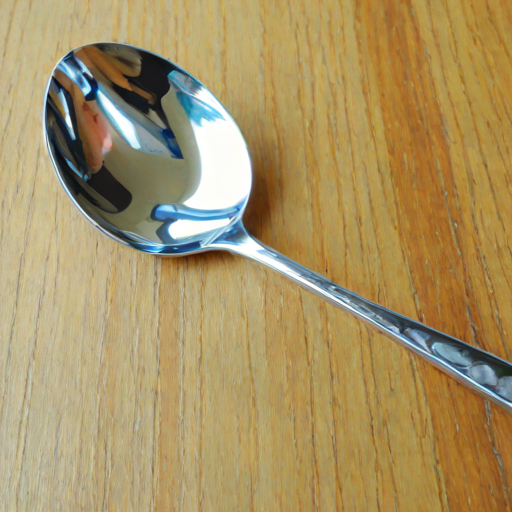

  0%|          | 0/4 [00:00<?, ?it/s]

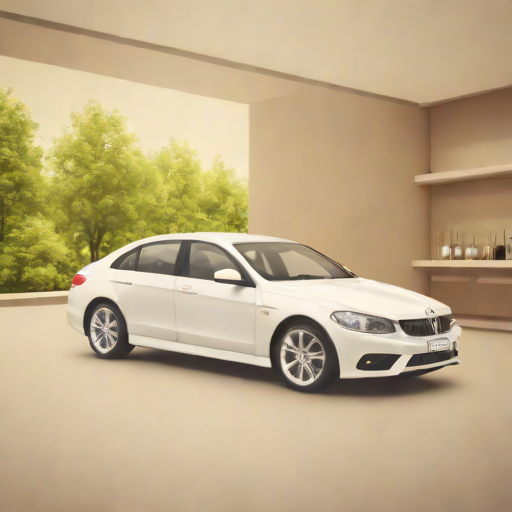

image_embeds torch.Size([1, 1024])


50it [00:00, 240.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

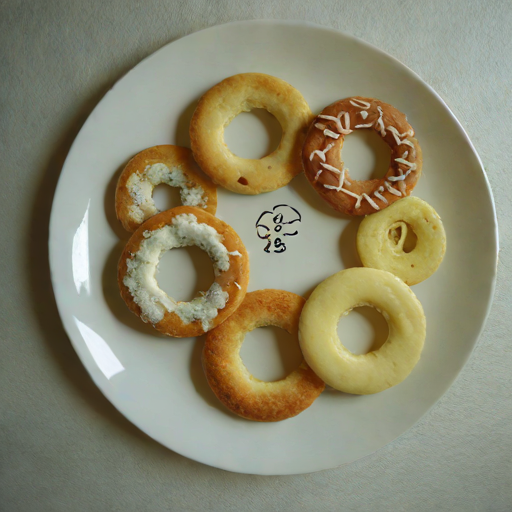

In [19]:
seed_value = 42

torch.manual_seed(seed_value)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)

# from IPython.display import Image, display
# generator = Generator4Embeds(num_inference_steps=4, device=device)


# path of ground truth: /home/ldy/Workspace/THINGS/images_set/test_images
k = 170
image_embeds = emb_img_test[k:k+1]
print("image_embeds", image_embeds.shape)
gen = torch.Generator(device=device)
gen.manual_seed(seed_value)
image = generator.generate(image_embeds, generator=gen)
display(image)


gen.manual_seed(seed_value)
image = generator.generate(emb_eeg_test[k:k+1], generator=gen)
display(image)


# k = 0
gen.manual_seed(seed_value)
eeg_embeds = emb_eeg_test[k:k+1]
print("image_embeds", eeg_embeds.shape)
h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=50, guidance_scale=5.0,generator=gen)
image = generator.generate(h.to(dtype=torch.float16), generator=gen)
display(image)

In [20]:
import os
import torch

# Assuming `generator`, `pipe`, and `emb_eeg_test` are predefined and properly set up
# `device` should also be defined (e.g., 'cuda' or 'cpu')

def create_dirs(base_dir, subdirs):
    os.makedirs(base_dir, exist_ok=True)
    for subdir in subdirs:
        dir_path = os.path.join(base_dir, str(subdir))
        os.makedirs(dir_path, exist_ok=True)

def generate_and_save_images(k_values, base_dir='THINGS', num_seeds=30):
    for k in k_values:
        k_dir = os.path.join(base_dir, str(k))
        eeg_embeds = emb_eeg_test[k:k+1]  # Assuming emb_eeg_test is indexed by k
        for seed in range(num_seeds):
            gen = torch.Generator(device=device).manual_seed(seed)
            h = pipe.generate(c_embeds=eeg_embeds, num_inference_steps=50, guidance_scale=5.0, generator=gen)
            image = generator.generate(h.to(dtype=torch.float16), generator=gen)
            
            # Assuming `image` is a PIL Image or similar; if it's a tensor, you'll need to convert it
            image_file = os.path.join(k_dir, f"{seed}.png")  # Save as PNG
            image.save(image_file)

# Create 'THIN GS' directory and subdirectories for given k values
k_values = [10, 11, 20, 58, 177, 93, 141, 160, 100, 108, 111, 115]
base_dir = 'THINGS/0-500'
create_dirs(base_dir, k_values)

# Generate and save images
generate_and_save_images(k_values, base_dir)

50it [00:00, 238.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 253.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 254.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 253.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.70it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 224.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 210.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 227.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 254.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 251.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 247.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 126.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 232.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 227.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 236.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 236.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 251.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 220.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 233.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 228.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 226.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 127.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 247.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 232.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 145.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 173.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 173.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 150.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 183.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 190.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 177.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 172.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 143.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 171.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 180.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 149.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 174.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 140.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 146.26it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 189.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 217.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 253.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 226.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 113.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 124.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 175.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 117.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 182.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 226.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 206.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 207.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 205.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 116.10it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 193.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 233.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 228.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 233.14it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 225.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 227.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 221.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.23it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 186.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 188.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 126.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 171.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 160.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 221.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 114.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 226.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 197.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.51it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.29it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.28it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 185.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 163.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 212.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 135.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 166.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 149.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 139.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 93.50it/s] 


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 221.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 236.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 192.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 135.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 142.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 129.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 166.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 136.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 200.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 175.33it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 116.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 231.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 227.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.66it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 249.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.04it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 247.97it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 250.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.89it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 232.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 118.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 220.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 233.88it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 232.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 231.49it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 226.45it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 214.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 232.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.80it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 223.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 231.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 236.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 212.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 203.08it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 112.81it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.60it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 213.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 229.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 226.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 218.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.73it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.52it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 236.78it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 240.13it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.85it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 236.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.90it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.94it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 224.03it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 174.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 178.65it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 164.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 148.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 87.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.43it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 246.63it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 232.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 215.30it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 226.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 228.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 212.02it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.84it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 218.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.20it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 236.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 228.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.61it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.76it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 219.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 233.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 231.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 218.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.93it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 196.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.42it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.55it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 130.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 241.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.05it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.27it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.50it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 236.31it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 232.15it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.77it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 233.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.91it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.06it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.92it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 218.01it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 214.62it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 234.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 214.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 248.09it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 226.57it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 242.16it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 244.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.11it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 224.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.40it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 236.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 243.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 121.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 212.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 229.44it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.32it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 245.38it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 239.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 231.83it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 235.24it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 224.53it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 221.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 228.95it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 225.58it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 229.98it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 225.64it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 223.00it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 228.99it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 207.67it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 238.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 218.82it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 237.37it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 216.71it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 232.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 230.86it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 147.35it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 106.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 184.87it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 123.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 159.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 139.18it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 81.82it/s] 


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 173.46it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 180.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 95.49it/s] 


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 101.59it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 127.74it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 97.89it/s] 


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 117.19it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 149.17it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 103.68it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 172.48it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 153.75it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 138.54it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 185.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 141.96it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 132.79it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 105.56it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 142.34it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 135.72it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 169.47it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 102.12it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 144.36it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 141.69it/s]


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 99.31it/s] 


  0%|          | 0/4 [00:00<?, ?it/s]

50it [00:00, 98.25it/s]


  0%|          | 0/4 [00:00<?, ?it/s]